In [188]:
%matplotlib inline
from utils.conduit import conduit_connect
from utils.sql import query_database

In [189]:
import matplotlib.pyplot as plt, pandas as pd

In [250]:
connection = conduit_connect('datahub-dev-db', 'datahub-dev')

logged in
conduit is already running
processes: [11751, 11754]
connecting to database
connected


## how many companies in datahub have a corresponding companies house company number?

In [239]:
sql = '''
with matched_companies as (
    select
        id,
        company_number
        
    from company_company
    
    where company_number is not null
        and company_number not in ('', 'NotRegis', 'n/a', 'Not reg', 'N/A')

), n_companies as (
    select
        count(id)
        
    from company_company
    
), duplicates as (
    select
        company_number,
        count(1)

    from matched_companies

    group by 1
    
    having count(1) > 1

), n_duplicates as (
    select
        sum(count) as count
        
    from duplicates
    
), n_matches as (
    select
        count(1)
        
    from matched_companies
    
), results as (
    select
        n_companies.count as n_companies,
        n_matches.count as n_matches,
        n_duplicates.count as n_duplicates,
        n_matches.count - n_duplicates.count as n_unique_matches
      
    from n_companies join n_matches on 1=1
        join n_duplicates on 1=1
        
)

select * from results

'''

df = query_database(connection, sql)
df.head()

,n_companies,n_matches,n_duplicates,n_unique_matches
0,100391,10715,531,10184


In [226]:
sql = '''
with n_companies as (
    select
        count(id)
        
    from company_company
    
), y as (
    select
        2 as test
)

select * from n_companies join y on 1=1
'''

df = query_database(connection, sql)
df.head()

,count,test
0,100391,2


In [205]:
sql = '''
select
    count(id)
        
from company_company
'''

df = query_database(connection, sql)
df

,count
0,100391


In [204]:
type(rows[0][0])

str

In [155]:
sql = '''
select
    count(company_number) as n_matched
    
from company_company

where company_number is not null
    and company_number != ''
    and company_number not in ('NotRegis', 'n/a', 'Not reg', 'N/A')

'''

df = query_database(connection, sql)
n_matched = df['n_matched'].values[0]
df

,n_matched
0,10714


In [156]:
sql = '''
select
    count(1) as n_companies
    
from company_company
  
'''

df = query_database(connection, sql)
n_companies = df['n_companies'].values[0]
df.head()

,n_companies
0,100390


In [124]:
index = ['n_matched', 'n_companies']
columns = ['count']
values = [(n_matched,), (n_companies,)]
df = pd.DataFrame(values, index=index, columns=columns)
df['percent'] = 100 * df['count'] / n_companies
df

,count,percent
n_matched,10714,10.672378
n_companies,100390,100.000000


## how many companies in datahub are linked to the same companies house company number? i.e. are duplicates of the same company

In [126]:
sql = '''
with matched_companies as (
    select
        id,
        company_number

    from company_company

    where company_number is not null
        and company_number != ''
        and company_number not in ('NotRegis', 'n/a', 'Not reg', 'N/A')
    
), duplicates as (
    select
        company_number,
        count(1)
        
    from matched_companies
    
    group by 1
    
    having count(1) > 1
    
)

select sum(count) as n_duplicates from duplicates 

'''

df = query_database(connection, sql)
n_duplicates = df['n_duplicates'].values[0]
df

,n_duplicates
0,531


In [132]:
index = ['unique_match', 'duplicate']
columns = ['count']
values = [
    (n_matched - n_duplicates,),
    (n_duplicates,),
]
df = pd.DataFrame(values, columns=columns, index=index)
df['percent'] = 100 * df['count'] / n_matched
df['percent'] = df['percent'].map(lambda x: '{:.3f}'.format(x))
df

,count,percent
unique_match,10183,95.044
duplicate,531,4.956


In [131]:
index = ['unique_match', 'duplicate', 'unmatched']
columns = ['count']
values = [
    (n_matched - n_duplicates,),
    (n_duplicates,),
    (n_companies - n_matched,)
]
df = pd.DataFrame(values, columns=columns, index=index)
df['percent'] = 100 * df['count'] / n_companies
df['percent'] = df['percent'].map(lambda x: '{:.3f}'.format(x))
df

,count,percent
unique_match,10183,10.143
duplicate,531,0.529
unmatched,89676,89.328


## how many companies in datahub have sector data

In [247]:
import datetime

now = datetime.datetime.now()

sql = '''
with n_companies as (
    select
        count(id) as n_companies
        
    from company_company
    
), n_sectors as (
    select
        count(distinct sector_id) as n_sectors
        
    from company_company
    
), n_matched_companies as (
    select
        count(sector_id) as n_matched_companies
        
    from company_company
        
), results as (
    select
        n_companies,
        n_sectors,
        n_matched_companies,
        '{now}' as timestamp
        
    from n_companies join n_sectors on 1=1
        join n_matched_companies on 1=1
        
)

select * from results

'''.format(now=now)

df = query_database(connection, sql)
df.head()

,n_companies,n_sectors,n_matched_companies,timestamp
0,100391,249,96705,2019-10-09 16:11:52.411851


In [148]:
sql = ''' 
select
    count(sector_id) as n_companies_with_sector_data,
    count(1) as n_companies

from company_company

'''
df = query_database(connection, sql)
df['percent_with_sector'] = 100 * df['n_companies_with_sector_data'] / df['n_companies']
df.head()

,n_companies_with_sector_data,n_companies,percent_with_sector
0,96705,100390,96.329316


### top sectors

In [149]:
sql = '''
with level_2 as (                                                                                                                                                                                           
  select id, parent_id, segment from metadata_sector where level = 2                                                                                                                                        
), level_1 as (                                                                                                                                                                                             
  select id, parent_id, segment from metadata_sector where level = 1                                                                                                                                        
), level_0 as (                                                                                                                                                                                             
  select id, segment from metadata_sector where level = 0                                                                                                                                                   
), level_012 as (                                                                                                                                                                                           
  select                                                                                                                                                                                                    
    l2.id,                                                                                                                                                                                                  
    concat(l0.segment, ':', l1.segment, ':', l2.segment) as segment                                                                                                                                         
                                                                                                                                                                                                            
  from level_2 l2 join level_1 l1 on l2.parent_id = l1.id                                                                                                                                                   
    join level_0 l0 on l1.parent_id = l0.id                                                                                                                                                                 
                                                                                                                                                                                                            
), level_01 as (                                                                                                                                                                                            
  select                                                                                                                                                                                                    
    l1.id,                                                                                                                                                                                                  
    concat(l1.segment, ':', l0.segment) as segment                                                                                                                                                          
                                                                                                                                                                                                            
  from level_1 l1 join level_0 l0 on l1.parent_id = l0.id                                                                                                                                                   
                                                                                                                                                                                                            
), segments as (                                                                                                                                                                                             
    select id, segment from level_0 union                                                                                                                                                                   
    select id, segment from level_01 union                                                                                                                                                                  
    select id, segment from level_012                                                                                                                                                                       
)   

select
    segment,
    count(1) as n_companies
    
from company_company l join segments r on l.sector_id = r.id

where sector_id is not null

group by 1

order by 2 desc

'''

df = query_database(connection, sql)
df.head()

,segment,n_companies
0,Retail,41039
1,ICT,8835
2,Software and Computer Services Business to Bus...,7446
3,"Clothing, Footwear and Fashion",5232
4,Advanced Engineering,4069


## how many companies in datahub have made orders?

In [257]:
import datetime
now = datetime.datetime.now()

sql = '''
select
    count(distinct id) as n_companies,
    count(distinct company_id) as n_companies_with_orders,
    '{now}'::Timestamp
    
from order_order
    
'''.format(now=now)

df = query_database(connection, sql)
df.index = ['n_companies']
df['percent'] = 100 * df['n_companies_with_orders'] / n_companies
df

,n_companies,n_companies_with_orders,timestamp,percent
n_companies,268,23,2019-10-10 10:37:17.755141,0.022911


In [258]:
df.values

array([[268, 23, Timestamp('2019-10-10 10:37:17.755141'),
        0.022910648470963243]], dtype=object)

In [262]:
df.to_dict(orient='records')

[{'n_companies': 268,
  'n_companies_with_orders': 23,
  'percent': 0.022910648470963243,
  'timestamp': Timestamp('2019-10-10 10:37:17.755141')}]

## how many companies in datahub have export countries field filled in?

In [169]:
sql = ''' select table_name from information_schema.tables where table_schema='public' '''
df = query_database(connection, sql)
df[df['table_name'].str.startswith('company')]

,table_name
9,company_list_companylist
39,company_advisor_user_permissions
40,company_onelisttier
42,company_company_export_to_countries
43,company_advisor_groups
44,company_exportexperiencecategory
45,company_company_future_interest_countries
47,company_onelistcoreteammember
48,company_companieshousecompany
49,company_contact


In [170]:
sql = '''
select
    count(distinct company_id)
    
from company_company_export_to_countries
    
'''

df = query_database(connection, sql)
df.index = ['n_companies']
df['percent'] = 100 * df['count'] / n_companies
df

,count,percent
n_companies,18,0.01793


## how many companies in datahub have future countries of interest field filled in?

In [173]:
sql = '''
select
    count(distinct company_id)
    
from company_company_future_interest_countries
    
'''

df = query_database(connection, sql)
df.index = ['n_companies']
df['percent'] = 100 * df['count'] / n_companies
df

,count,percent
n_companies,17,0.016934


## how many orders are created a day/week/month?

,date,count
0,2017-07-20 00:00:00+00:00,7
1,2017-07-24 00:00:00+00:00,1
2,2017-07-25 00:00:00+00:00,6
3,2017-07-26 00:00:00+00:00,4
4,2017-07-27 00:00:00+00:00,1


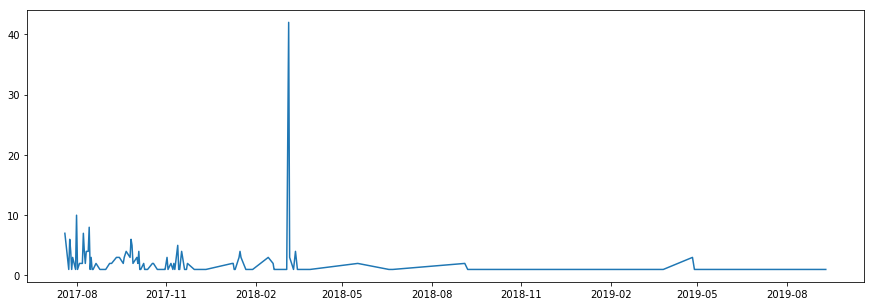

In [183]:
sql = '''
select
    date_trunc('day', created_on) as date,
    count(created_on) as count
    
from order_order

group by 1

order by 1

'''

df = query_database(connection, sql)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['date'], df['count'])
df.head()

### week

,date,count
0,2017-07-17 00:00:00+00:00,7
1,2017-07-24 00:00:00+00:00,15
2,2017-07-31 00:00:00+00:00,14
3,2017-08-07 00:00:00+00:00,23
4,2017-08-14 00:00:00+00:00,14


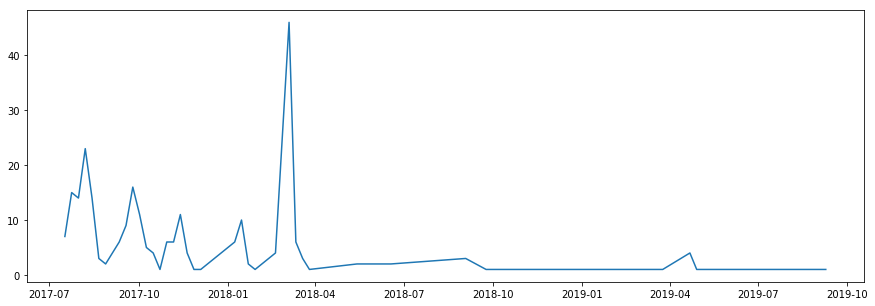

In [185]:
sql = '''
select
    date_trunc('week', created_on) as date,
    count(created_on) as count
    
from order_order

group by 1

order by 1

'''

df = query_database(connection, sql)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['date'], df['count'])
df.head()

### month

,date,count
0,2017-07-01 00:00:00+00:00,23
1,2017-08-01 00:00:00+00:00,55
2,2017-09-01 00:00:00+00:00,35
3,2017-10-01 00:00:00+00:00,23
4,2017-11-01 00:00:00+00:00,26


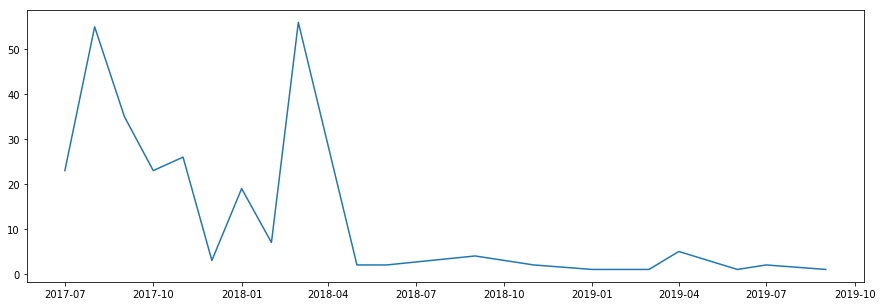

In [186]:
sql = '''
select
    date_trunc('month', created_on) as date,
    count(created_on) as count
    
from order_order

group by 1

order by 1

'''

df = query_database(connection, sql)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['date'], df['count'])
df.head()